**Gestione Energetica ed Automazione negli Edifici (GEAE) A.A. 2024/2025**

*Tutto il materiale didattico messo a disposizione degli studenti (compresi script, markdown, presentazioni, video e Virtual Classroom) è da utilizzarsi esclusivamente per scopi didattici e nell’ambito del corso di “gestione energetica e automazione negli edifici”. È vietata ogni forma di utilizzo diverso, redistribuzione e pubblicazione on line. Per ogni eventuale dubbio o richiesta contattare il titolare del corso prof. Alfonso Capozzoli a alfonso.capozzoli@polito.it*

# Pattern recognition through SAX - BONUS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('../data/pydata.csv', parse_dates=['date_time'])
df_info = pd.read_csv('../data/df_info.csv')

In [3]:
df['date'] = df['date_time'].dt.date
df['time'] = df['date_time'].dt.time

In [4]:
# use a decision tree to determine the periods using only "time" as a feature
from sklearn.tree import DecisionTreeRegressor

# convert time to a numerical value
df['time_numeric'] = df['time'].apply(lambda x: x.hour + x.minute/60)


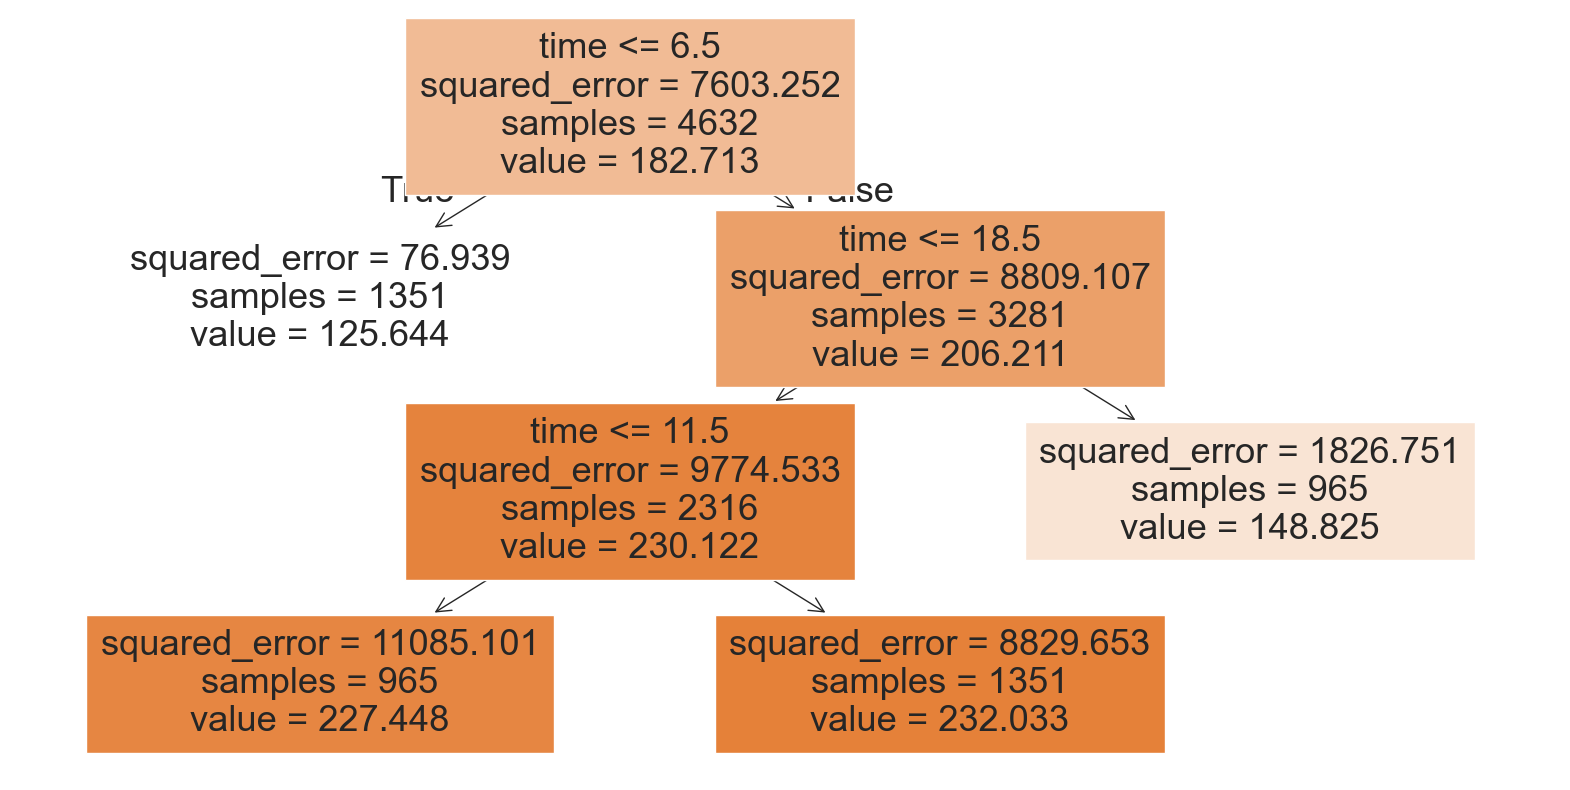

In [5]:
X = df[['time_numeric']]
y = df[['energy_h']]

regressor = DecisionTreeRegressor(min_samples_leaf=800)

regressor.fit(X, y)
# plot tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(regressor, feature_names=['time'], filled=True)
plt.show()

In [6]:
# assing the periods to the data
df['period'] = regressor.predict(df[['time_numeric']])

# convert period to string according to unique values
unique_values = df['period'].unique()

# Step 2: Create a mapping of each unique numeric value to a string label
mapping = {value: f'Period_{i+1}' for i, value in enumerate(unique_values)}

# Step 3: Map the numeric values in 'period' to their respective labels
df['period'] = df['period'].map(mapping)


### Aggregating the time series using Piecewise Aggregate Approximation (PAA)

In [7]:
df_PAA = df.groupby(['date', 'period']).agg({'energy_h': 'mean'}).reset_index()
df_PAA.rename(columns={'energy_h': 'energy_h_mean'}, inplace=True)

### Encoding of the aggregated time series in 5 symbols using the lookup table

In [8]:
# Define quantiles to use as breakpoints
quantiles = df_PAA['energy_h_mean'].quantile([0.2, 0.4, 0.6, 0.8]).values

# Adjust the function to use these quantile-based breakpoints
def assign_symbol(value):
    if value <= quantiles[0]:
        return 'A'
    elif value <= quantiles[1]:
        return 'B'
    elif value <= quantiles[2]:
        return 'C'
    elif value <= quantiles[3]:
        return 'D'
    else:
        return 'E'

# Apply the modified function
df_PAA['symbol'] = df_PAA['energy_h_mean'].apply(assign_symbol)

In [9]:
pydata = pd.merge(df, df_PAA[['date', 'period', 'symbol']], on=['date', 'period'], how='left')

### Visualization of the SAX transformation

In [10]:
pivot_df = pydata.pivot_table(index='date', columns='time', values='symbol', aggfunc='first')

# Define custom color mapping
symbol_colors = {
    'A': '#5591ff',
    'B': '#40c8ff',
    'C': '#ffd954',
    'D': '#7fdd56',
    'E': '#ed6f6f'
}

In [11]:
cmap = ListedColormap([symbol_colors[key] for key in sorted(symbol_colors.keys())])

symbol_to_num = {symbol: idx for idx, symbol in enumerate(sorted(symbol_colors.keys()))}
numeric_data = pivot_df.replace(symbol_to_num)

C:\Users\silvio.brandi\AppData\Local\Temp\ipykernel_22884\2388236346.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_data = pivot_df.replace(symbol_to_num)


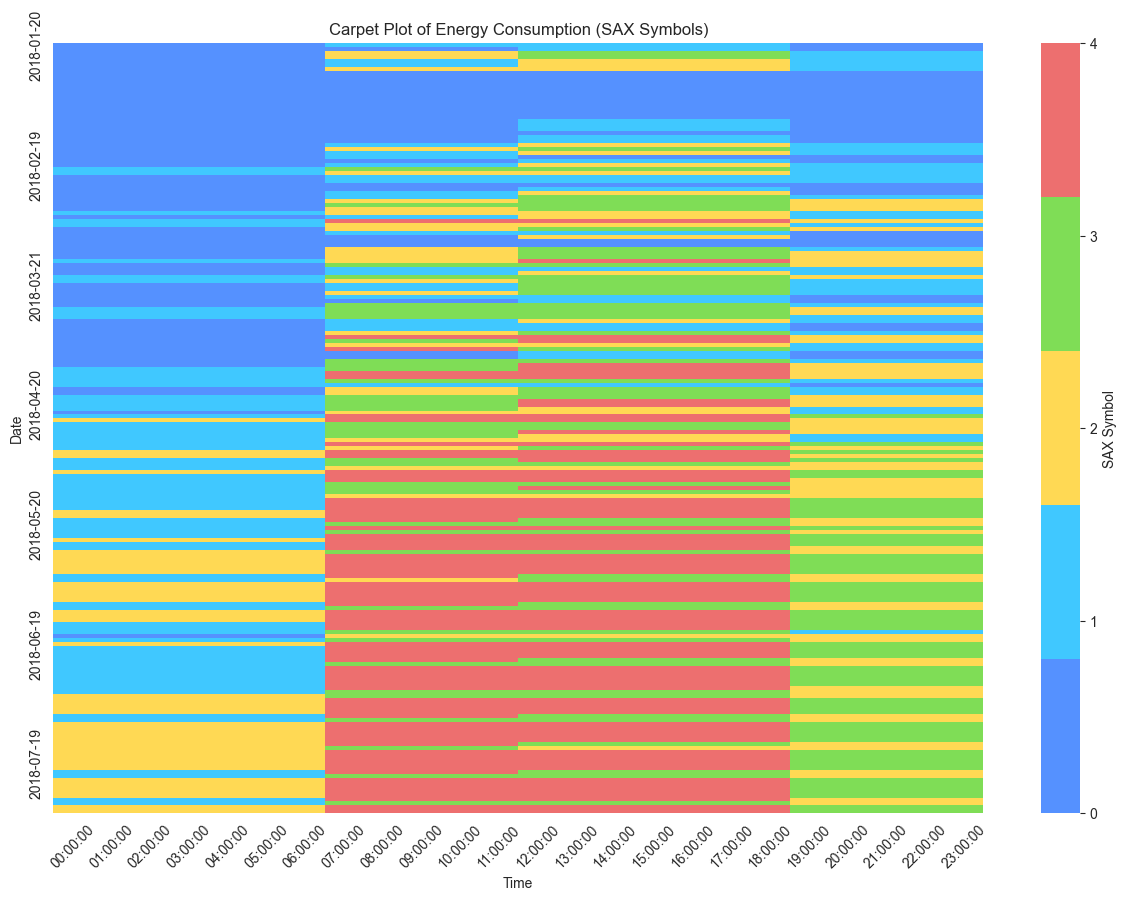

In [12]:
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_data, cmap=cmap, cbar_kws={'ticks': list(symbol_to_num.values()), 
                                               'label': 'SAX Symbol'}, yticklabels=30)
plt.title('Carpet Plot of Energy Consumption (SAX Symbols)')
plt.xlabel('Time')
plt.ylabel('Date')

plt.xticks(rotation=45)
plt.show()

## Construction of the daily words as a combination of subsequent symbols 

### Pivot the PAA DataFrame to have the symbols of each period in columns

In [13]:
df_PAA_pivot = df_PAA.pivot(index='date', columns='period', values='symbol').reset_index()

### Ensuring the order of the periods

In [14]:
periods = ['Period_1', 'Period_2', 'Period_3','Period_4']
df_PAA_pivot = df_PAA_pivot[['date'] + periods]

### Concatenating the symbols of the periods to form the daily words

In [15]:
df_PAA_pivot['word'] = df_PAA_pivot[periods].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [16]:
word_counts = df_PAA_pivot['word'].value_counts().reset_index()
word_counts.columns = ['word', 'count']

df_PAA_pivot = pd.merge(df_PAA_pivot, word_counts, on='word')

In [17]:
df_PAA_pivot['word'] = pd.Categorical(df_PAA_pivot['word'], categories=word_counts['word'], ordered=True)

### Plot the frequency of words

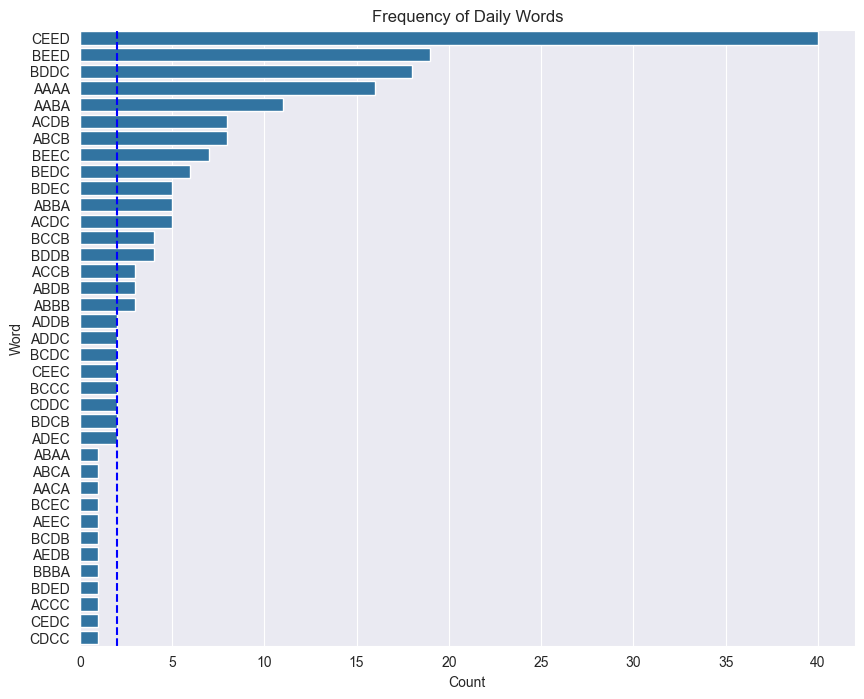

In [25]:
# Plot frequency of words
plt.figure(figsize=(10, 8))
sns.countplot(y='word', data=df_PAA_pivot, order=word_counts['word'])
plt.axvline(0.05 * df_PAA_pivot['word'].value_counts().max(), color='blue', linestyle='--')
plt.title('Frequency of Daily Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

## Determining motifs and discords

### Setting a threshold for motifs and discords

In [19]:
threshold = 0.1 * df_PAA_pivot['count'].max()

df_PAA_pivot['pattern'] = df_PAA_pivot['count'].apply(lambda x: 'discord' if x < threshold else 'motif')

pydata = pd.merge(pydata, df_PAA_pivot[['date', 'word', 'pattern']], on='date', how='left')

pydata['time_dt'] = pd.to_datetime(pydata['time'].astype(str), format='%H:%M:%S')

### Plot the motifs and discords

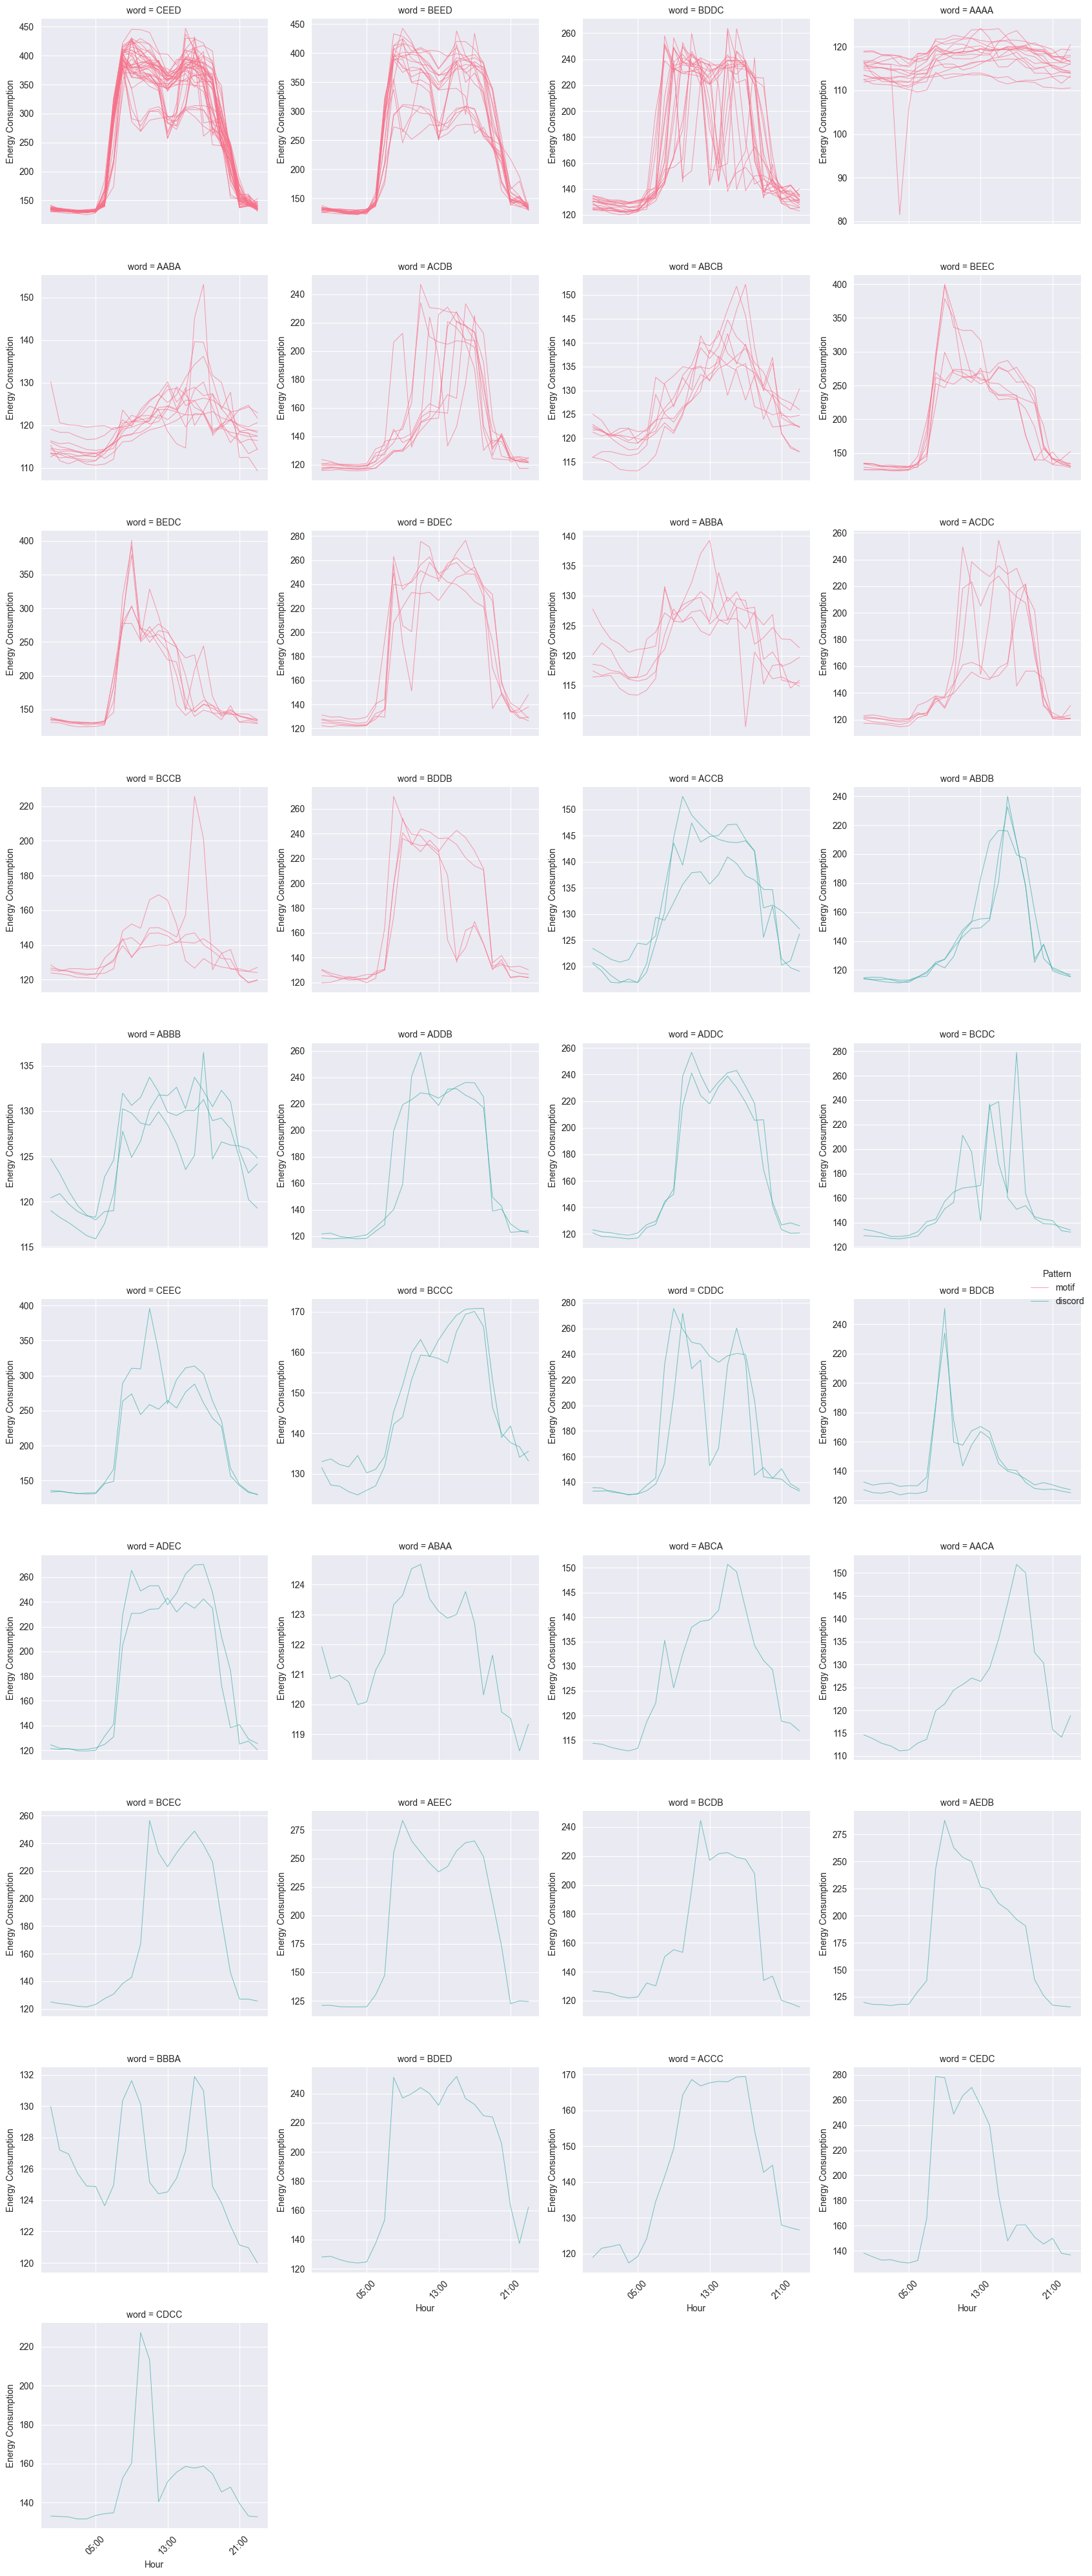

In [24]:
palette = sns.color_palette("husl", len(pydata['pattern'].unique()))


g = sns.FacetGrid(pydata, col='word', col_wrap=4, height=4, sharey=False, hue='pattern', palette=palette)
g.map_dataframe(sns.lineplot, x='time_dt', y='energy_h', estimator=None, units='date', lw=0.7, alpha=0.7)

# Adjust plot aesthetics
for ax in g.axes.flatten():
    ax.set_xlabel('Hour')
    ax.set_ylabel('Energy Consumption')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=8))
    plt.setp(ax.get_xticklabels(), rotation=45)

# Add a legend for 'pattern'
g.add_legend(title="Pattern")

plt.tight_layout()
plt.show()
